# Baseline with Hugging Face models

It is a baseline solution using Hugging Face's `BERT` for `Named Entity Recognition` (`NER`). This code loads the dataset, perform NER using BERT, and evaluates it against the provided labels for persons, organizations, and locations.
Other models from the [Hugging Face ](https://huggingface.co/docs/transformers/en/index) can be used instead.

The [CoNLL-2003 on Hugging Face](https://huggingface.co/datasets/conll2003) dataset is used.

## Setting up

Install all necessary packages and initialize the library names.

In [ ]:
#!pip install -U pip

In [ ]:
!pip install -U transformers datasets pandas scikit-learn

In [2]:
!pip install --upgrade pyopenssl

Defaulting to user installation because normal site-packages is not writeable
  Using cached pyOpenSSL-24.2.1-py3-none-any.whl.metadata (13 kB)
Using cached pyOpenSSL-24.2.1-py3-none-any.whl (58 kB)
  Attempting uninstall: pyopenssl
    Found existing installation: pyOpenSSL 23.0.0
    Uninstalling pyOpenSSL-23.0.0:
      Successfully uninstalled pyOpenSSL-23.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aws-sam-cli 1.81.0 requires pyopenssl==23.0.0, but you have pyopenssl 24.2.1 which is incompatible.
aws-sam-cli 1.81.0 requires requests==2.28.2, but you have requests 2.32.3 which is incompatible.
aws-sam-cli 1.81.0 requires tomlkit==0.11.7, but you have tomlkit 0.12.3 which is incompatible.
aws-sam-cli 1.81.0 requires typing-extensions~=4.4.0, but you have typing-extensions 4.11.0 which is incompatible.
aws-sam-cli 1.81.0 requires tzlocal==3.0, but you 

In [1]:
from pathlib import Path
from collections import Counter

import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, pipeline
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


/home/leo/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/leo/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-11-06 15:02:18.049413: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 15:02:18.185173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the f

In [2]:
DATA_PATH = Path('../data/external/hf')
train_file_path = DATA_PATH / 'conll2003_transformed.train.csv'
validation_file_path = DATA_PATH / 'conll2003_transformed.validation.csv'
test_file_path = DATA_PATH / 'conll2003_transformed.test.csv'

## Data loading

I do not train a new model. I use pretrained models so I can merge `train`, `validation` and `test` datasets and use the compound dataset for the model evaluation.

In [3]:
def load_data(file_path, usecols=None, nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows)
    print(f"Loaded {df.shape} {file_path}, {df.columns =}")
    return df

In [4]:
used_columns = "text persons organizations locations".split()

train_df = load_data(train_file_path, usecols=used_columns)
train_df.head(1)

Loaded (14041, 4) ../data/external/hf/conll2003_transformed.train.csv, df.columns =Index(['text', 'persons', 'locations', 'organizations'], dtype='object')


,text,persons,locations,organizations
0,EU rejects German call to boycott British lamb .,NaN,NaN,EU


In [5]:
counter = Counter(train_df.text.str.len())
print(counter)  # Output: Counter({20: 1, 10: 1, 41: 1})

Counter({17: 330, 19: 308, 20: 304, 21: 287, 18: 261, 16: 260, 22: 255, 23: 224, 31: 201, 33: 196, 32: 194, 28: 179, 30: 173, 27: 173, 24: 169, 26: 163, 29: 163, 25: 154, 15: 152, 52: 146, 35: 146, 39: 143, 37: 141, 38: 139, 36: 137, 40: 133, 34: 133, 51: 129, 44: 122, 47: 121, 63: 120, 60: 116, 50: 116, 53: 113, 42: 113, 41: 113, 43: 110, 48: 107, 49: 104, 45: 104, 14: 103, 65: 102, 46: 101, 10: 97, 64: 95, 61: 92, 59: 92, 57: 90, 62: 90, 56: 85, 12: 82, 55: 80, 58: 79, 54: 76, 67: 72, 8: 72, 9: 72, 11: 66, 66: 62, 7: 60, 13: 59, 5: 56, 78: 51, 73: 51, 68: 50, 71: 50, 178: 49, 152: 48, 125: 48, 81: 47, 114: 46, 144: 45, 136: 45, 108: 45, 112: 45, 179: 44, 148: 44, 116: 44, 138: 44, 109: 44, 77: 43, 158: 43, 96: 43, 74: 42, 139: 42, 120: 42, 170: 41, 175: 41, 117: 41, 89: 41, 115: 41, 121: 41, 180: 41, 126: 41, 147: 41, 97: 41, 177: 40, 99: 40, 166: 39, 167: 39, 72: 39, 70: 38, 182: 37, 134: 37, 102: 37, 176: 37, 87: 37, 135: 37, 105: 37, 69: 37, 106: 37, 164: 37, 181: 36, 107: 36, 118

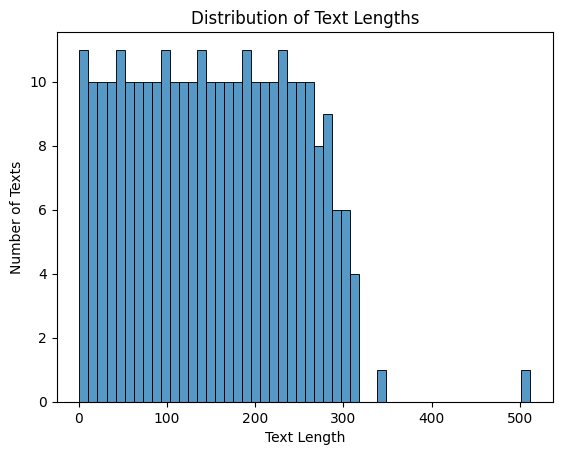

In [6]:
# Convert the Counter object to a DataFrame for plotting
df = pd.DataFrame({'Text Length': list(counter.keys()), 'Count': list(counter.values())})

# Create the histogram
sns.histplot(data=df, x='Text Length', bins=50)
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.title('Distribution of Text Lengths')
plt.show()

In [7]:
validation_df = load_data(validation_file_path, usecols=used_columns)
validation_df.head(1)

Loaded (3250, 4) ../data/external/hf/conll2003_transformed.validation.csv, df.columns =Index(['text', 'persons', 'locations', 'organizations'], dtype='object')


,text,persons,locations,organizations
0,CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTE...,NaN,NaN,LEICESTERSHIRE


In [8]:
test_df = load_data(test_file_path, usecols=used_columns)
test_df.head(10)

Loaded (3453, 4) ../data/external/hf/conll2003_transformed.test.csv, df.columns =Index(['text', 'persons', 'locations', 'organizations'], dtype='object')


,text,persons,locations,organizations
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...",CHINA,JAPAN,NaN
1,Nadim Ladki,Nadim Ladki,NaN,NaN
2,"AL-AIN , United Arab Emirates 1996-12-06",NaN,AL-AIN;United Arab Emirates,NaN
3,Japan began the defence of their Asian Cup tit...,NaN,Japan;Syria,NaN
4,But China saw their luck desert them in the se...,NaN,China;Uzbekistan,NaN
5,China controlled most of the match and saw sev...,Igor Shkvyrin,China,NaN
6,Oleg Shatskiku made sure of the win in injury ...,Oleg Shatskiku,NaN,NaN
7,The former Soviet republic was playing in an A...,NaN,NaN,NaN
8,Despite winning the Asian Games title two year...,NaN,Uzbekistan,NaN
9,Two goals from defensive errors in the last si...,NaN,Japan;Syria,NaN


In [23]:
# Concatenate all df-s
def load_data(file_path, usecols=None, nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows)
    print(f"Loaded {df.shape} {file_path}, {list(df.columns) =}")
    return df
    
def load_all_data(data_path, used_columns, nrows=None):
    suffixes = "train test validation".split()
    
    all_df = pd.concat([load_data(
        data_path / f"conll2003_transformed.{suffix}.csv",
        usecols=used_columns, 
        nrows=nrows
    ) for suffix in suffixes])
    print(f"Summary df: {all_df.shape}, {list(all_df.columns) =}")
    return all_df


DATA_PATH = Path('../data/external/hf')
used_columns = "text persons organizations locations".split()
nrows = None
df = load_all_data(DATA_PATH, used_columns=used_columns, nrows=nrows)

Loaded (14041, 4) ../data/external/hf/conll2003_transformed.train.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Loaded (3453, 4) ../data/external/hf/conll2003_transformed.test.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Loaded (3250, 4) ../data/external/hf/conll2003_transformed.validation.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Summary df: (20744, 4), list(all_df.columns) =['text', 'persons', 'locations', 'organizations']


## Data Exploration

There are several observations after manually exploring the test data:
- several `text` are outliers with length > 350 and < 5
- `persons`, `locations`, `organizations` field can hold several values with `;` as a separator
- there are duplicated values of `persons`, `locations`, `organizations` in a single row


### Deduplication

In [10]:
def duplicate_search(df, column):
    """Print duplicates"""
    def print_dups(x):
         if x:
            elements = [str(el.strip()) for el in str(x).split(";") if el.strip() != '']
            elements_set = set()
            diff = { val for val in elements if (val in elements_set or elements_set.add(val)) }
            if diff:
                res.append(f"diff: {diff} - {x}")
    res = []
    try:
        df[column].apply(print_dups)
    except AttributeError as ex:
        print(x, type(x))
        raise ex
    return res

In [11]:
duplicate_search(all_df, "persons")[:10]

["diff: {'Peres'} - Peres;Arafat;Peres",
 "diff: {'Sampras'} - Sampras;Mark Philippoussis;Sampras",
 "diff: {'Brunswijk'} - Brunswijk;Freddy Pinas;Brunswijk;Ro Gajadhar",
 "diff: {'Pinas'} - Pinas;Pinas;Brunswijk",
 "diff: {'Kevorkian'} - Kevorkian;Geoffrey Fieger;Smith;David;James Poland;Kevorkian",
 "diff: {'Springer'} - Driller;Trulsen;Springer;Sobotzik;Max;Thon;Wilmots;Springer",
 "diff: {'Mickelson'} - Mickelson;Mayfair;Mickelson",
 "diff: {'Mickelson'} - Mickelson;Mickelson;Mayfair",
 "diff: {'Agassi'} - Agassi;Stich;Agassi",
 "diff: {'Dole'} - Gore;Dole;Gingrich;Jack Kemp;Dole"]

#### Conclusions

My assumption is to remove duplicates only when we calculate evaluation metrics. It doesn't make a big difference if we have found a single name or two such names. In most use cases, we need to find a name, but one or more times it doesn't matter.
Still, I will deduplicate names only when I evaluate results. I do not remove duplicates in the data preprocessing stage.

## NE extraction

In [12]:
def load_model():
    model_name = "dslim/bert-base-NER"  # Pre-trained BERT model for NER
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForTokenClassification.from_pretrained(model_name)
    return tokenizer, model

# Predict entities using Hugging Face NER pipeline
def predict_entities_with_hf(texts, tokenizer, model):
    ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") #, device=0)
    predictions = [ner_pipeline(text) for text in texts]
    return predictions

# Post-process predictions and extract persons, organizations, and locations
def extract_entities(predictions):
    persons, organizations, locations = [], [], []

    for pred in predictions:
        person_set, org_set, loc_set = set(), set(), set()
        for entity in pred:
            if entity['entity_group'] == 'PER':
                person_set.add(entity['word'])
            elif entity['entity_group'] == 'ORG':
                org_set.add(entity['word'])
            elif entity['entity_group'] == 'LOC':
                loc_set.add(entity['word'])
        persons.append(";".join(person_set))
        organizations.append(";".join(org_set))
        locations.append(";".join(loc_set))

    return persons, organizations, locations

def predict_entities(df, tokenizer, model):
    texts = df['text']
    predictions = predict_entities_with_hf(texts, tokenizer, model)
    persons, organizations, locations = extract_entities(predictions)
    df.loc[:, "persons_pred"] = persons
    df.loc[:, "organizations_pred"] = organizations
    df.loc[:, "locations_pred"] = locations
    return df    

In [13]:
tokenizer, model = load_model()
tokenizer, model

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(BertTokenizer(name_or_path='dslim/bert-base-NER', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 BertForTokenClassification(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embeddin

In [14]:
rows = 10
debug_df = all_df[:rows]
predictions = predict_entities(debug_df, tokenizer, model)
print(predictions.shape)
predictions.head()

/home/leo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


(10, 7)


/tmp/ipykernel_455406/962104515.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "persons_pred"] = persons
/tmp/ipykernel_455406/962104515.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "organizations_pred"] = organizations
/tmp/ipykernel_455406/962104515.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,text,persons,locations,organizations,persons_pred,organizations_pred,locations_pred
0,EU rejects German call to boycott British lamb .,NaN,NaN,EU,,EU,
1,Peter Blackburn,Peter Blackburn,NaN,NaN,Peter Blackburn,,
2,BRUSSELS 1996-08-22,NaN,BRUSSELS,NaN,,,BRUSSELS
3,The European Commission said on Thursday it di...,NaN,NaN,European Commission,,European Commission,
4,Germany 's representative to the European Unio...,Werner Zwingmann,Germany;Britain,European Union,Werner Zwingmann,European Union,Germany;Britain


In [15]:
predictions_df = predict_entities(all_df, tokenizer, model)
print(predictions_df.shape)

(20744, 7)


In [62]:
predictions_df.head()

,text,persons,locations,organizations,persons_pred,organizations_pred,locations_pred
0,EU rejects German call to boycott British lamb .,NaN,NaN,EU,,EU,
1,Peter Blackburn,Peter Blackburn,NaN,NaN,Peter Blackburn,,
2,BRUSSELS 1996-08-22,NaN,BRUSSELS,NaN,,,BRUSSELS
3,The European Commission said on Thursday it di...,NaN,NaN,European Commission,,European Commission,
4,Germany 's representative to the European Unio...,Werner Zwingmann,Germany;Britain,European Union,Werner Zwingmann,European Union,Germany;Britain


## Evaluation (Deprecated)

I will try to use evaluation method from the Hugging Face `evaluate` package.

In [87]:
!pip install seqeval

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=21390d2efc54416bb00b0d97471a08d33bf3ef0d0eab734d1e9124db240c3d60
  Stored in directory: /home/leo/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [93]:
import evaluate as hf_evaluate

# Refactored evaluate function using Hugging Face's evaluate package
def evaluate_ner(df, persons_pred, orgs_pred, locs_pred):
    # Initialize the seqeval metric
    seqeval_metric = hf_evaluate.load("seqeval")

    # Prepare true labels (split multi-entity strings by ';')
    persons_true = [p.split(";") if p is not None and not p else [] for p in df["persons"]]
    orgs_true = [o.split(";") if o is not None and not o else [] for o in df["organizations"]]
    locs_true = [l.split(";") if l is not None and not l else [] for l in df["locations"]]

    # Evaluate persons
    person_results = seqeval_metric.compute(predictions=[p.split(";") for p in persons_pred],
                                            references=persons_true)
    print("Persons F1 Score:", person_results["overall_f1"])

    # Evaluate organizations
    org_results = seqeval_metric.compute(predictions=[o.split(";") for o in orgs_pred],
                                         references=orgs_true)
    print("Organizations F1 Score:", org_results["overall_f1"])

    # Evaluate locations
    loc_results = seqeval_metric.compute(predictions=[l.split(";") for l in locs_pred],
                                         references=locs_true)
    print("Locations F1 Score:", loc_results["overall_f1"])

    return {
        "persons_f1": person_results["overall_f1"],
        "organizations_f1": org_results["overall_f1"],
        "locations_f1": loc_results["overall_f1"]
    }

In [ ]:
evaluate_ner(df, persons_pred=persons, orgs_pred=organizations, locs_pred=locations)

In [101]:
# Using sklearn

from sklearn.metrics import precision_recall_fscore_support

# Helper function to flatten the list of predictions and true labels
def flatten_labels(preds, refs):
    """
    Flatten the predictions and references (true labels) for evaluation.
    We create a flat list of labels for multi-label classification.
    """
    flat_preds = [entity for sublist in preds for entity in sublist]
    flat_refs = [entity for sublist in refs for entity in sublist]
    return flat_preds, flat_refs

# Refactored evaluate function using scikit-learn's precision_recall_fscore_support
def evaluate_ner(df, persons_pred, orgs_pred, locs_pred):
    # Prepare true labels (split multi-entity strings by ';')
    persons_true = [p.split(";") if p is not None else [] for p in df["persons"]]
    orgs_true = [o.split(";") if o is not None else [] for o in df["organizations"]]
    locs_true = [l.split(";") if l is not None else [] for l in df["locations"]]
    
    print(persons_pred[:5])
    print(persons_true[:5])

    # Flatten the lists for scikit-learn evaluation
    persons_flat_pred, persons_flat_true = flatten_labels(persons_pred, persons_true)
    orgs_flat_pred, orgs_flat_true = flatten_labels(orgs_pred, orgs_true)
    locs_flat_pred, locs_flat_true = flatten_labels(locs_pred, locs_true)

    print(persons_flat_pred[:5])
    print(persons_flat_true[:5])
    # Evaluate persons
    persons_metrics = precision_recall_fscore_support(persons_flat_true, persons_flat_pred, average='weighted')
    print("Persons - Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*persons_metrics[:3]))

    # Evaluate organizations
    orgs_metrics = precision_recall_fscore_support(orgs_flat_true, orgs_flat_pred, average='weighted')
    print("Organizations - Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*orgs_metrics[:3]))

    # Evaluate locations
    locs_metrics = precision_recall_fscore_support(locs_flat_true, locs_flat_pred, average='weighted')
    print("Locations - Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*locs_metrics[:3]))

    return {
        "persons_precision": persons_metrics[0],
        "persons_recall": persons_metrics[1],
        "persons_f1": persons_metrics[2],
        "organizations_precision": orgs_metrics[0],
        "organizations_recall": orgs_metrics[1],
        "organizations_f1": orgs_metrics[2],
        "locations_precision": locs_metrics[0],
        "locations_recall": locs_metrics[1],
        "locations_f1": locs_metrics[2],
    }


In [102]:
persons[:5]

['Andrew Clyde;Kelly;Louie Gohmert;Lloyd Smucker;Trump;Timothy Kelly',
 'Nicole Carroll;Haynes Boone;Rob;Laura Lee Prather',
 'Matt Zeller;Kate Bolduan;Jon Stewart;Chuck Schum;Stewart;Zeller',
 'Andrew Clyde;Kelly;Louie Gohmert;Lloyd Smucker;Trump;Timothy Kelly',
 'Jake;Paul LeB;Pat Toomey;Too']

In [103]:
metrics = evaluate_ner(df, persons_pred=persons, orgs_pred=organizations, locs_pred=locations)
print(metrics)

['Andrew Clyde;Kelly;Louie Gohmert;Lloyd Smucker;Trump;Timothy Kelly', 'Nicole Carroll;Haynes Boone;Rob;Laura Lee Prather', 'Matt Zeller;Kate Bolduan;Jon Stewart;Chuck Schum;Stewart;Zeller', 'Andrew Clyde;Kelly;Louie Gohmert;Lloyd Smucker;Trump;Timothy Kelly', 'Jake;Paul LeB;Pat Toomey;Too']
[['Louie Gohmert', 'Timothy Kelly', 'Andrew Clyde', 'Lloyd Smucker'], ['Laura Lee Prather', 'Haynes Boone', 'Nicole Carroll'], ['Pat Toomey', 'Kate Bolduan', 'Matt Zeller', 'Jon Stewart'], ['Louie Gohmert', 'Timothy Kelly', 'Andrew Clyde', 'Lloyd Smucker'], ['Pat Toomey', 'Joe Manchin', 'Paul Leblanc', 'Jake Tapper', 'Matt Zeller', 'Denis Mcdonough']]
['A', 'n', 'd', 'r', 'e']
['Louie Gohmert', 'Timothy Kelly', 'Andrew Clyde', 'Lloyd Smucker', 'Laura Lee Prather']


ValueError: Found input variables with inconsistent numbers of samples: [4170, 34663]

## Custom evaluation

The Hugging Face `evaluate` package requires too much configuration, so I fell back to the custom evaluation. 
It allows me to fully control calculations.

In [25]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_binary(df):
    def calculate_metrics(row):
        true_set = set(row[column].split(';'))
        pred_set = set(row[column+'_pred'].split(';'))
        
        tp = len(true_set & pred_set)  # True Positives
        fp = len(pred_set - true_set)  # False Positives
        fn = len(true_set - pred_set)  # False Negatives
        support = len(true_set)        # Support: the number of true values (in 'persons')        
        return pd.Series([tp, fp, fn, support])
    
    overall_metrics = {}    
    for column in 'persons organizations locations'.split():
        # Apply the function to each row
        df[['TP_'+column, 'FP_'+column, 'FN_'+column, 'support_'+column]] = df.apply(calculate_metrics, axis=1)
        
        # Calculate precision, recall, F1 for each row
        df['precision_'+column] = df['TP_'+column] / (df['TP_'+column] + df['FP_'+column])
        df['recall_'+column] = df['TP_'+column] / (df['TP_'+column] + df['FN_'+column])
        df['F1_'+column] = 2 * (df['precision_'+column] * df['recall_'+column]) / (df['precision_'+column] + df['recall_'+column])
        
        # Fill NaN values (where precision/recall is undefined) with 0
        df.fillna(0, inplace=True)
        
        # Calculate overall precision, recall, F1-score, and support
        overall_metrics[column] ={
            "precision": round(sum(df['precision_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "recall": round(sum(df['recall_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "F1": round(sum(df['F1_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "support": int(df['support_'+column].sum())
        }
    return df, overall_metrics   


In [26]:
# Example DataFrame
data = {
    'persons': ["Andrew Clyde;Kelly;Louie Gohmert", "Lloyd Smucker;Trump", "Timothy Kelly;Trump"],
    'organizations': ["Andrew Clyde;Kelly;Louie Gohmert", "Lloyd Smucker;Trump", "Timothy Kelly;Trump"],
    'locations': ["Florida;Orlando", "San Francisco;California;Napa County", "Mexican"],
    'persons_pred': ["Andrew Clyde;Louie Gohmert;something", "Trump;Lloyd Smucker", "Timothy Kelly;some"],
    'organizations_pred': ["Andrew Clyde;Louie Gohmert;something", "Trump;Lloyd Smucker", "Timothy Kelly;some"],
    'locations_pred': ["Florida;Orlando;something", "San Francisco;California;Napa County;some","Mexican;New York"],
}
df_test = pd.DataFrame(data)

df_test, overall_metrics = evaluate_binary(df_test)

In [27]:
df_test

,persons,organizations,locations,persons_pred,organizations_pred,locations_pred,TP_persons,FP_persons,FN_persons,support_persons,...,precision_organizations,recall_organizations,F1_organizations,TP_locations,FP_locations,FN_locations,support_locations,precision_locations,recall_locations,F1_locations
0,Andrew Clyde;Kelly;Louie Gohmert,Andrew Clyde;Kelly;Louie Gohmert,Florida;Orlando,Andrew Clyde;Louie Gohmert;something,Andrew Clyde;Louie Gohmert;something,Florida;Orlando;something,2,1,1,3,...,0.666667,0.666667,0.666667,2,1,0,2,0.666667,1.0,0.800000
1,Lloyd Smucker;Trump,Lloyd Smucker;Trump,San Francisco;California;Napa County,Trump;Lloyd Smucker,Trump;Lloyd Smucker,San Francisco;California;Napa County;some,2,0,0,2,...,1.000000,1.000000,1.000000,3,1,0,3,0.750000,1.0,0.857143
2,Timothy Kelly;Trump,Timothy Kelly;Trump,Mexican,Timothy Kelly;some,Timothy Kelly;some,Mexican;New York,1,1,1,2,...,0.500000,0.500000,0.500000,1,1,0,1,0.500000,1.0,0.666667


In [70]:
predictions_df.head(5)

,text,persons,locations,organizations,persons_pred,organizations_pred,locations_pred
0,EU rejects German call to boycott British lamb .,NaN,NaN,EU,,EU,
1,Peter Blackburn,Peter Blackburn,NaN,NaN,Peter Blackburn,,
2,BRUSSELS 1996-08-22,NaN,BRUSSELS,NaN,,,BRUSSELS
3,The European Commission said on Thursday it di...,NaN,NaN,European Commission,,European Commission,
4,Germany 's representative to the European Unio...,Werner Zwingmann,Germany;Britain,European Union,Werner Zwingmann,European Union,Germany;Britain


In [68]:
overall_metrics

{'persons': {'precision': 0.714, 'recall': 0.714, 'F1': 0.714, 'support': 7},
 'organizations': {'precision': 0.714,
  'recall': 0.714,
  'F1': 0.714,
  'support': 7},
 'locations': {'precision': 0.681, 'recall': 1.0, 'F1': 0.806, 'support': 6}}

In [78]:
predictions_metrics_df, overall_metrics = evaluate_binary(predictions_df)

In [79]:
predictions_metrics_df.head()

,text,persons,locations,organizations,persons_pred,organizations_pred,locations_pred,TP_persons,FP_persons,FN_persons,...,precision_organizations,recall_organizations,F1_organizations,TP_locations,FP_locations,FN_locations,support_locations,precision_locations,recall_locations,F1_locations
0,EU rejects German call to boycott British lamb .,0,0,EU,,EU,,0,0,0,...,1.0,1.0,1.0,0,0,0,0,0.0,0.0,0.0
1,Peter Blackburn,Peter Blackburn,0,0,Peter Blackburn,,,1,0,0,...,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2,BRUSSELS 1996-08-22,0,BRUSSELS,0,,,BRUSSELS,0,0,0,...,0.0,0.0,0.0,1,0,0,1,1.0,1.0,1.0
3,The European Commission said on Thursday it di...,0,0,European Commission,,European Commission,,0,0,0,...,1.0,1.0,1.0,0,0,0,0,0.0,0.0,0.0
4,Germany 's representative to the European Unio...,Werner Zwingmann,Germany;Britain,European Union,Werner Zwingmann,European Union,Germany;Britain,1,0,0,...,1.0,1.0,1.0,2,0,0,2,1.0,1.0,1.0


In [80]:
overall_metrics

{'persons': {'precision': 0.516,
  'recall': 0.59,
  'F1': 0.543,
  'support': 10022},
 'organizations': {'precision': 0.848,
  'recall': 0.861,
  'F1': 0.852,
  'support': 9225},
 'locations': {'precision': 0.836,
  'recall': 0.845,
  'F1': 0.838,
  'support': 10476}}

## Whole pipeline

### Code

In [28]:
import json

def load_data(file_path, usecols=None, nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows)
    print(f"Loaded {df.shape} {file_path}, {list(df.columns) =}")
    return df
    
def save_results(output_file_path, metrics_file_path, df, metrics):
    df.to_csv(output_file_path, index=False)
    print(f"Results saved into {output_file_path}, rows: {df.shape[0]}")

    print(metrics)
    with open(metrics_file_path, "w", encoding='utf-8') as fp:
        json.dump(metrics, fp, check_circular=True)
    print(f"Metrics saved into {metrics_file_path}")    

    
def evaluate_baseline(data_file_path, output_file_path, metrics_file_path, do_cleanup=True, nrows=None):
    # Load data
    used_columns = "text persons organizations locations".split()
    df = load_data(data_file_path, usecols=used_columns, nrows=nrows)
    print(f"Loaded {df.shape}")

    if do_cleanup:
        df = data_cleanup(df)
        print(f"Cleaned up to {df.shape}")

    df.fillna('', inplace=True)
    print("Loading model")
    tokenizer, model = load_model()
    print("Extracting NE") 
    df_pred = predict_entities(df, tokenizer, model)
    print(f'Extracted. Res df: {df_pred.shape}, {df_pred.columns}')
    # print(df)

    # Evaluate predictions against true labels
    out_df, overall_metrics = evaluate_binary(df_pred)

    # Save the predictions to a CSV file (required format for submission)
    save_results(output_file_path, metrics_file_path, df=out_df, metrics=overall_metrics)
    print("Finish")
    return out_df, overall_metrics

### Evaluation on `conll2003`

In [30]:
from_source = 'external/hf'
dataset_name = "conll2003_transformed.all"
extractor_type = 'hf'

data_file_path = f"../data/{from_source}/{dataset_name}.csv"
output_file_path = f"../data/{from_source}/{extractor_type}/with_scores.csv"
metrics_file_path = f"../data/{from_source}/{extractor_type}/scores.json"
nrows = None

out_df, overall_metrics = evaluate_baseline(data_file_path, output_file_path, metrics_file_path, do_cleanup=False, nrows=nrows)

Loaded (20744, 4) ../data/external/hf/conll2003_transformed.all.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Loaded (20744, 4)
Loading model


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Extracting NE
Extracted. Res df: (20744, 7), Index(['text', 'persons', 'locations', 'organizations', 'persons_pred',
       'organizations_pred', 'locations_pred'],
      dtype='object')
Results saved into ../data/external/hf/hf/with_scores.csv, rows: 20744
{'persons': {'precision': 0.796, 'recall': 0.827, 'F1': 0.807, 'support': 24248}, 'organizations': {'precision': 0.93, 'recall': 0.935, 'F1': 0.932, 'support': 23191}, 'locations': {'precision': 0.921, 'recall': 0.925, 'F1': 0.922, 'support': 23498}}
Metrics saved into ../data/external/hf/hf/scores.json
Finish


In [31]:
overall_metrics

{'persons': {'precision': 0.796,
  'recall': 0.827,
  'F1': 0.807,
  'support': 24248},
 'organizations': {'precision': 0.93,
  'recall': 0.935,
  'F1': 0.932,
  'support': 23191},
 'locations': {'precision': 0.921,
  'recall': 0.925,
  'F1': 0.922,
  'support': 23498}}